In [1]:
%matplotlib inline
from __future__ import division
import h5py
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import brownian.bayes as s
from brownian import calc_P_x0, Pf, u
from freqdemod import h5ls

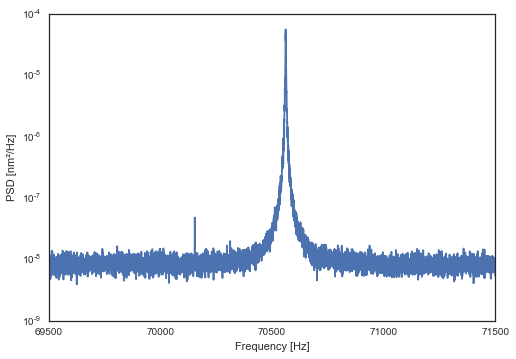

In [3]:
fh = h5py.File('brownian173033.h5', 'r')
f = fh['x'][:]
PSD = fh['y'][:]
m = (f > 69500) & (f < 71500)
plt.semilogy(fh['x'][m], fh['y'][m])
plt.xlabel("Frequency [Hz]")
plt.ylabel(u"PSD [nm²/Hz]")

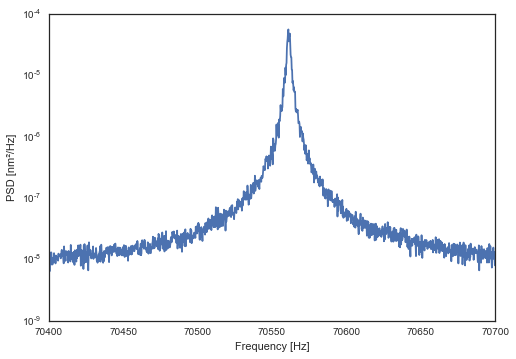

In [4]:
f = fh['x'][:]
m = (f > 70400) & (f < 70700)
plt.semilogy(fh['x'][m], fh['y'][m])
plt.xlabel("Frequency [Hz]")
plt.ylabel(u"PSD [nm²/Hz]")

In [6]:
fh['y'].attrs.items()

[(u'unit', 'nm^2/Hz'),
 (u'name', 'Power Spectral Density of Position Fluctuations'),
 (u'label', 'PSD [nm^2/Hz]'),
 (u'label_latex', '$P_{\\delta x} \\: [\\mathrm{nm}^2/\\mathrm{Hz}]'),
 (u'help',
  'Power spectral density, determined by converting peak-to-peak voltage to nm'),
 (u'n_avg', 32.0)]

In [12]:
d = s.np2data(f, PSD, 32, fmin=70400, fmax=70700,
              kc=3.5, Q=20000, sigma_Q=15000, sigma_kc=2.5,
              Pdet=1e-8, sigma_Pdet=3e-8, # Pdet, sigma_Pdet not required
             )

In [9]:
traces = s.sample_pymc3(d)

Applied log-transform to Q and added transformed Q_log_ to model.
Applied log-transform to Pdet and added transformed Pdet_log_ to model.
Applied log-transform to kc and added transformed kc_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 12.8 sec

In [10]:
ppb = s.PlotPyMCBrownian(d, traces, 'test-data')

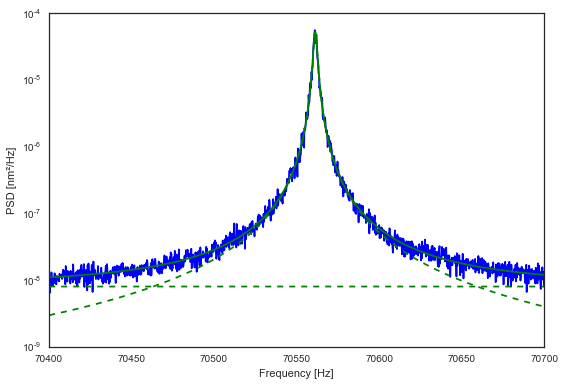

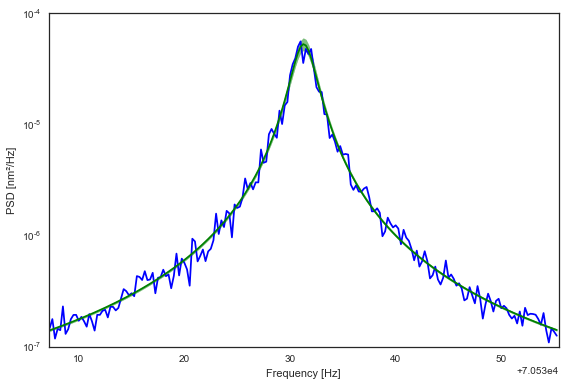

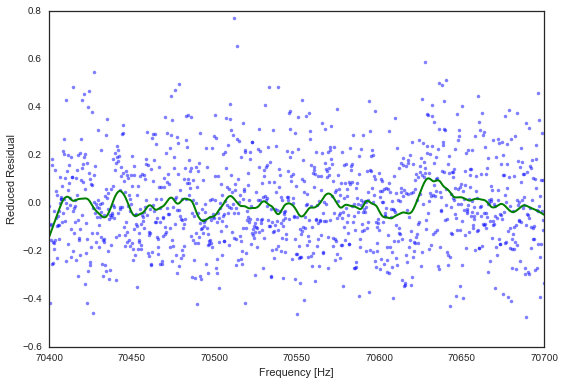

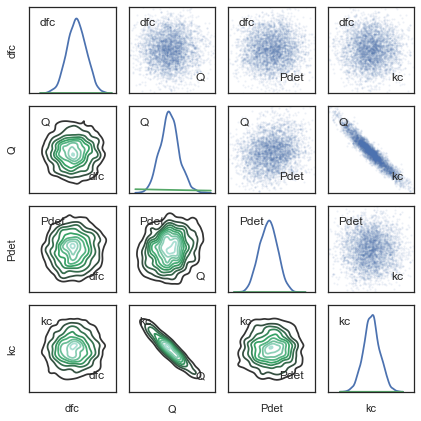

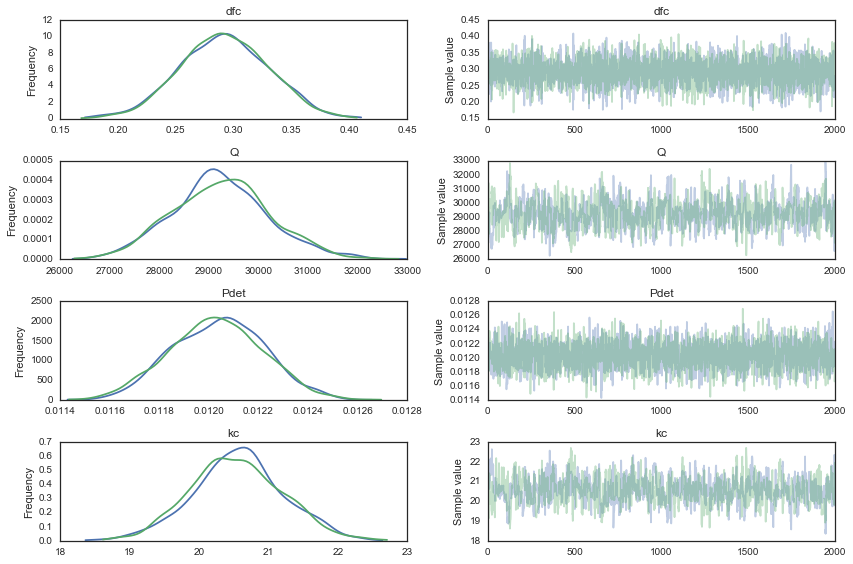

In [11]:
ppb.report(outfile='test-data',)

## Calculating dissipation $\Gamma$ using brownian data

First, get the values of the parameters sampled.

In [15]:
fc = traces.get_values('dfc') + d['mu_fc']  # Add mean cantilever frequency to dfc
kc = traces.get_values('kc')
Q = traces.get_values('Q')

Next, calculate $\Gamma$ using our samples.

In [43]:
def gamma(fc, kc, Q):
    return kc / (2*np.pi*fc * Q)

Gamma = gamma(fc, kc, Q)
Gamma

array([  1.58096425e-09,   1.58096425e-09,   1.57879890e-09, ...,
         1.49406466e-09,   1.48423144e-09,   1.82279370e-09])

`Gamma` is an array containing estimates calculated from each sample. The different estimates can be plotted:

In [44]:
import seaborn as sns  # Pretty plots of samples

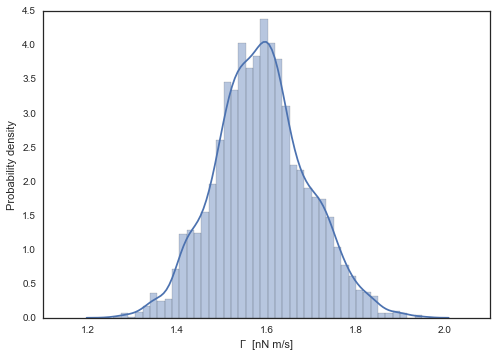

In [45]:
ax = sns.distplot(Gamma*1e9)
ax.set_xlabel(u"Γ  [nN m/s]")
ax.set_ylabel("Probability density")

And summarized with a mean and standard deviation:

In [48]:
print(u"Γ = {:.2f} ± {:.2f} [nN m/s]".format(
        Gamma.mean()*1e9,
        Gamma.std(ddof=1)*1e9)) # nN m /s

Γ = 1.59 ± 0.10 [nN m/s]
